#### Database structure:

Publications(pmid, year, title, abstract, ta_search) - 28M records, ta_search is a `tsvector` for full text search in both title and abstract

Citations(pmid_citing, pmid_cited) - approx. 60M records

CitationsCount(pmid, count) - can be created in 30+ minutes

In [5]:
import networkx as nx
import pandas as pd
import psycopg2 as pg_driver

from Bio import Entrez
Entrez.email = 'nikolay.kapralov@gmail.com'

In [6]:
def search(*terms):
    query=' '.join(terms)
    handle = Entrez.esearch(db='pubmed',  
                            retmax='100000',
                            retmode='xml', 
                            term=query)
    results = Entrez.read(handle)
    return results

In [16]:
class PubmedDatabaseHandler:  
    def __init__(self):
        self.fields = ['pmid', 'year', 'title', 'abstract']
        self.conn = pg_driver.connect(dbname='pubmed', user='biolabs', password='pubtrends', host='localhost')
        self.cursor = self.conn.cursor()
        
    def size(self):
        self.cursor.execute('SELECT COUNT(1) FROM Publications;')
        result = []
        
        for row in self.cursor:
            result.append(row)
            
        return result[0]
    
    def create_citation_count_table(self):
        query = f'SELECT pmid_cited AS pmid, COUNT(1) INTO CitationsCount FROM Citations GROUP BY pmid_cited'
        with self.conn:
            self.cursor.execute(query)
        
    def get_paper_by_id(self, pmid):
        query = f'SELECT {",".join(self.fields)} FROM Publications WHERE pmid={pmid}'
        result = []
        
        self.cursor.execute(query)
        for row in self.cursor:
            result.append(row)
            
        # No duplicate PMIDs should exist, otherwise there is a problem with data storage
        assert len(result) == 1
        
        return result[0]
    
    def get_top_cited_papers(self, year_min=None, year_max=None, limit=10):
        # TODO: use year range
        query = f'SELECT pmid, count FROM CitationsCount ORDER BY count DESC LIMIT {limit}';
        result = []
        
        self.cursor.execute(query)
        for row in self.cursor:
            result.append(row)
            
        assert len(result) == limit
        
        return result
    
    def get_papers_by_keywords(self, *keywords):
        return self.get_papers_by_keywords_pubmed(*keywords)
    
    # TODO: decrease execution time 
    def get_papers_by_keywords_local(self, *keywords):
        # Drop previous subset
        with self.conn:
            self.cursor.execute('DROP TABLE IF EXISTS PublicationsSubset;')
            
        # Make subset for new keywords
        tsquery = ' & '.join(keywords)
        query = f"SELECT * INTO PublicationsSubset FROM Publications WHERE ta_search @@ to_tsquery('{tsquery}');"
        print(query)
        with self.conn:
            self.cursor.execute(query)
            
    def get_papers_by_keywords_pubmed(self, *keywords):
        results = search(*keywords)
        pmids = [int(pmid) for pmid in results['IdList']]
        
        with self.conn:
            self.cursor.execute('SELECT pmid, year, title FROM Publications WHERE pmid = ANY(%s)', (pmids,))
            
        data = []
        for row in db_handler.cursor:
            data.append(list(row))
            
        return data
    
    def get_citation_timeline(self, pmid):
        query = 'SELECT P.pmid, P.year FROM Citations C JOIN Publications P ON P.pmid = C.pmid_citing WHERE C.pmid_cited=%s'

        with self.conn:
            self.cursor.execute(query, (pmid,))

        data = []
        for row in db_handler.cursor:
            data.append(list(row))

        return data
  
#     def build_citation_graph(self, size):
#         dg = nx.DiGraph()
# #         self.cursor.execute('SELECT pmid_citing, pmid_cited FROM Citations;')
        
#         edges = []
# #         for row in self.cursor:
# #             assert len(row) == 2
# #             assert isinstance(row[0], int)
# #             assert isinstance(row[1], int)
# #             edges.append(row)
        
#         for i in range(size):
#             edges.append((i+1, i+2))
#         return len(edges)
    
    def close():
        self.conn.close()

In [17]:
db_handler = PubmedDatabaseHandler()

#### Number of publications

In [ ]:
%time print(db_handler.size())

#### Get paper by PMID

In [ ]:
%time print(db_handler.get_paper_by_id(20545324))

#### Top cited papers

In [ ]:
papers = db_handler.get_top_cited_papers()
print('PMID, Number of citations')
for paper in papers:
    print(paper[0], paper[1], sep=', ')

#### TODO: Full text search in title and abstract

In [53]:
db_handler.get_papers_by_keywords('dna', 'methylation', 'clock')

SELECT * INTO PublicationsSubset FROM Publications WHERE ta_search @@ to_tsquery('dna & methylation & clock')


**Search terms via PubMed API**

In [14]:
data = db_handler.get_papers_by_keywords('dna', 'methylation', 'clock')
df = pd.DataFrame(data, columns = ['pmid', 'year', 'title'])

Text(0,0.5,'Number of papers')

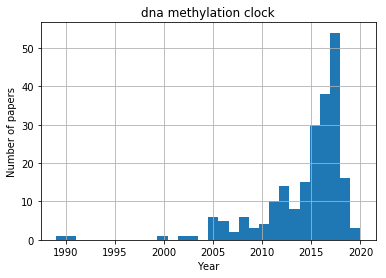

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

min_year = int(df['year'].min())
max_year = int(df['year'].max())
df['year'].hist(bins=max_year-min_year, range=(min_year, max_year+1))
plt.title('dna methylation clock')
plt.xlabel('Year')
plt.ylabel('Number of papers')

**Timeline of citations for one paper**

In [115]:
pmid = 1202204
data = db_handler.get_citation_timeline(pmid)
df = pd.DataFrame(data, columns=['pmid', 'year'])

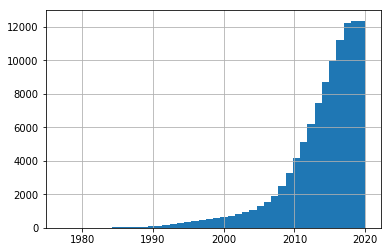

In [117]:
min_year = int(df['year'].min())
max_year = int(df['year'].max())
df['year'].hist(cumulative=True, bins=max_year-min_year, range=(min_year, max_year+1))

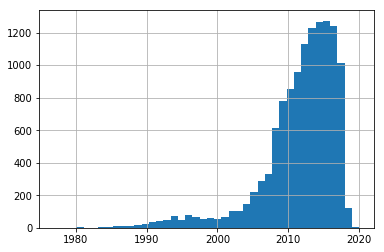

In [118]:
min_year = int(df['year'].min())
max_year = int(df['year'].max())
df['year'].hist(bins=max_year-min_year, range=(min_year, max_year+1))